In [1]:
from contextlib import contextmanager
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

@contextmanager
def unlimited_data_card():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)

    yield None

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [2]:
FIFA_PLAYERS_DATA = list((Path.cwd() / "fifa_players_data").glob("*"))
TOP_DISPLAY = 20

In [3]:
FIFA_PLAYERS_DATA

[PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_21.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_17.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_16.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_19.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_18.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_20.csv'),
 PosixPath('/home/michal/Documents/semestr-1/sieci-zlozone/projekt/fifa_players_data/players_15.csv')]

In [4]:
dataframes = []

for fifa_player_data_path, year in zip(sorted(FIFA_PLAYERS_DATA, key=lambda x: int(str(x).removesuffix(".csv").split("_")[-1])), range(15, 22)):
    df = pd.read_csv(fifa_player_data_path)
    df["year"] = year
    dataframes.append(df)

fifa_data = pd.concat(dataframes)

years = list(range(15,22))
fifa_data

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,year
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,15
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,...,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,15
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,...,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3,15
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,...,40+3,40+3,40+3,36+3,36+3,38+3,38+3,38+3,36+3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18939,256679,https://sofifa.com/player/256679/kevin-angulo/...,K. Angulo,Kevin Angulo,24,1996-04-13,176,73,Colombia,América de Cali,...,47+2,47+2,47+2,47+2,47+2,46+2,46+2,46+2,47+2,21
18940,257710,https://sofifa.com/player/257710/mengxuan-zhan...,Zhang Mengxuan,Mengxuan Zhang,21,1999-04-26,177,70,China PR,Chongqing Dangdai Lifan FC SWM Team,...,41+2,41+2,41+2,42+2,45+2,47+2,47+2,47+2,45+2,21
18941,250989,https://sofifa.com/player/250989/zhenghao-wang...,Wang Zhenghao,王政豪,20,2000-06-28,185,74,China PR,Tianjin TEDA FC,...,42+2,42+2,42+2,42+2,44+2,47+2,47+2,47+2,44+2,21
18942,257697,https://sofifa.com/player/257697/zitong-chen/2...,Chen Zitong,Zitong Chen,23,1997-02-20,186,80,China PR,Shijiazhuang Ever Bright F.C.,...,49+2,49+2,49+2,47+2,47+2,49+2,49+2,49+2,47+2,21


In [5]:
fifa_data.shape

len(fifa_data["short_name"].unique())

38843

In [6]:
fifa_data["club_name"].unique().shape

(954,)

In [7]:
import networkx as nx

graphs = {}

for idx, (year_1, year_2) in enumerate(zip(years[:-1], years[1:])):

    year_1_data = fifa_data[fifa_data["year"] == year_1]
    year_2_data = fifa_data[fifa_data["year"] == year_2]

    clubs_2 = year_2_data[["sofifa_id", "club_name"]].set_index("sofifa_id")
    clubs_1 = year_1_data[["sofifa_id", "club_name"]].set_index("sofifa_id")
    
    merged = clubs_2.join(clubs_1, how="inner", lsuffix="_last", rsuffix="_next")

    grouped = merged.reset_index().groupby(["club_name_last", "club_name_next"]).count().rename(columns={"sofifa_id": "count"}).reset_index()
    grouped = grouped[grouped.apply(lambda x: x["club_name_last"] != x["club_name_next"], axis=1)]
    graphs[idx] = nx.from_pandas_edgelist(df=grouped, source="club_name_last", target="club_name_next", edge_attr="count", create_using=nx.DiGraph())


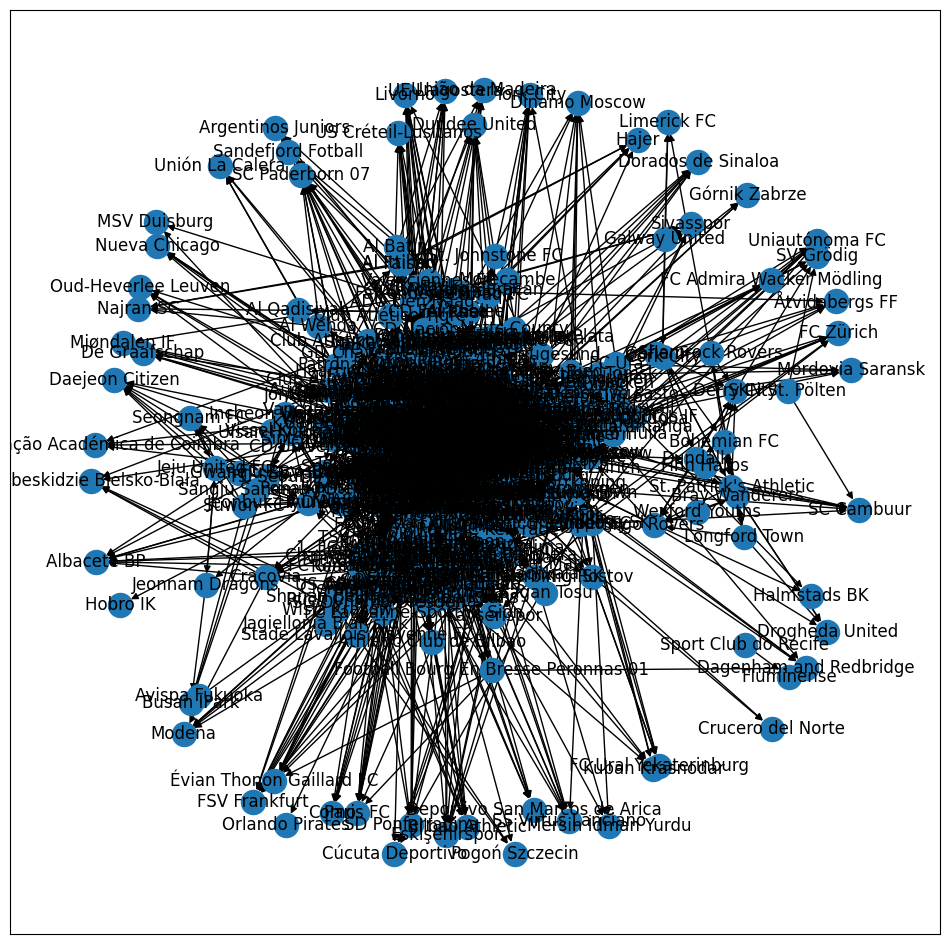

In [8]:
plt.figure(figsize=(12,12))
nx.draw_networkx(graphs[1], with_labels=True)


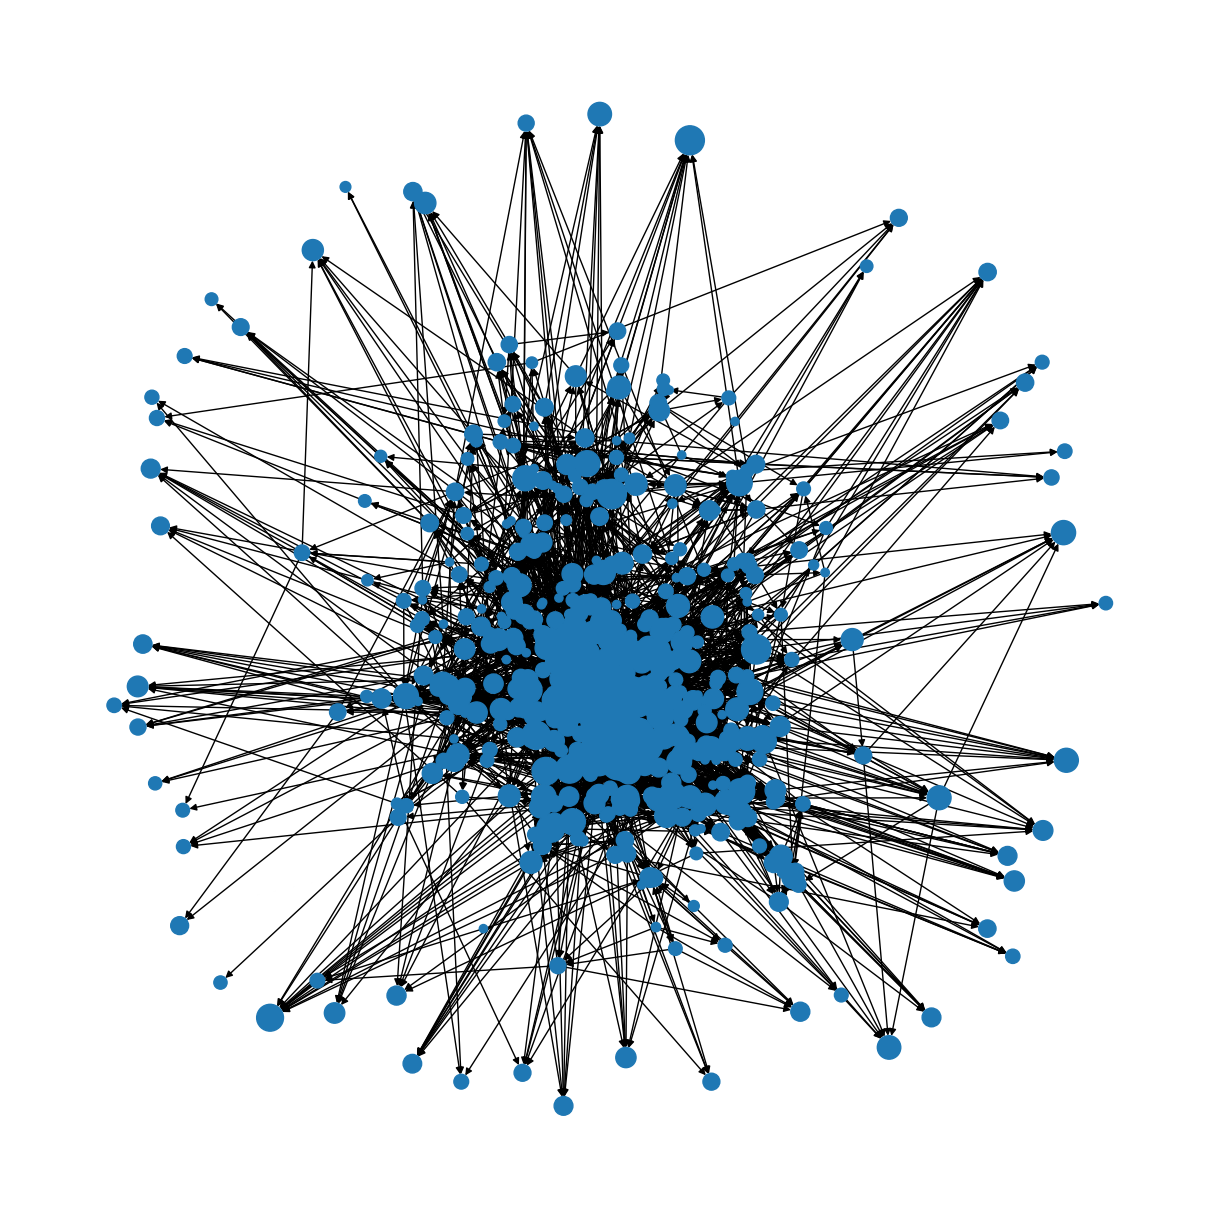

In [9]:
plt.figure(figsize=(12,12))
nx.draw(graphs[0], node_size=[rank * 100000 for rank in nx.pagerank(graphs[0]).values()], with_labels=False)

In [10]:
groups = list(nx.community.k_clique_communities(graphs[0].to_undirected(), k=3))

colors = ['#000000', '#800000', '#008000', '#808000', '#000080', '#800080', '#008080', '#c0c0c0', '#808080', '#ff0000', '#00ff00', '#ffff00', '#0000ff', '#ff00ff', '#00ffff', '#ffffff', '#000000', '#000033', '#000066', '#000099', '#0000cc', '#0000ff', '#003300', '#003333', '#003366', '#003399', '#0033cc', '#0033ff', '#006600', '#006633', '#006666', '#006699', '#0066cc', '#0066ff', '#009900', '#009933', '#009966', '#009999', '#0099cc', '#0099ff', '#00cc00', '#00cc33', '#00cc66', '#00cc99', '#00cccc', '#00ccff', '#00ff00', '#00ff33', '#00ff66', '#00ff99', '#00ffcc', '#00ffff', '#330000', '#330033', '#330066', '#330099', '#3300cc', '#3300ff', '#333300', '#333333', '#333366', '#333399', '#3333cc', '#3333ff', '#336600', '#336633', '#336666', '#336699', '#3366cc', '#3366ff', '#339900', '#339933']

matching = {}
for group, color in zip(groups, colors):
    for club in group:
        matching[club] = color

In [11]:
len(graphs[0].nodes)

635

In [12]:
len(matching)

564

In [13]:
# nx.draw(graphs[0], color=[matching[node] for node in graphs[0].nodes], with_labels=False)

In [14]:
from pyvis.network import Network
import networkx as nx

nt = Network()
nt.from_nx(graphs[0])
nt.show_buttons(filter_=['physics'])
nt.show('nx.html')

In [15]:
import seaborn as sns

Year 15-16
Wigan Athletic --> 33
Elche CF --> 28
Granada CF --> 27
FC Porto --> 25
Genoa --> 25
Aston Villa --> 25
Sampdoria --> 25
Hellas Verona --> 24
Olympique de Marseille --> 24
Queens Park Rangers --> 24
Rotherham United --> 23
Yeovil Town --> 23
Córdoba CF --> 22
Liverpool --> 22
Palermo --> 22
Bursaspor --> 22
Blackpool --> 22
Cambridge United --> 21
Portsmouth --> 21
Fulham --> 21


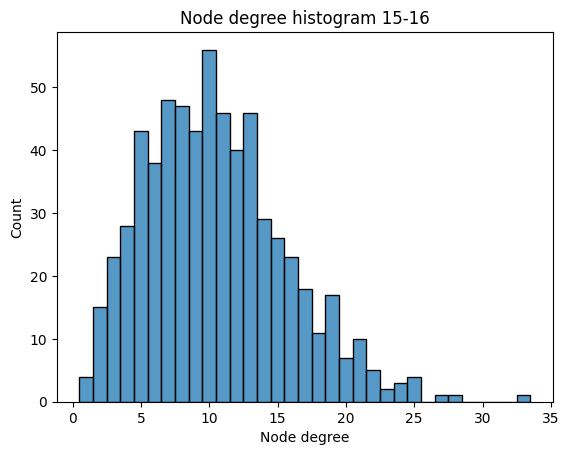

Year 16-17
Granada CF --> 35
Fulham --> 30
Sampdoria --> 28
Blackburn Rovers --> 27
Reading --> 27
RCD Espanyol --> 27
Sporting CP --> 26
Newcastle United --> 26
Middlesbrough --> 26
Quilmes Atlético Club --> 26
Elche CF --> 25
Oldham Athletic --> 25
Bristol City --> 25
Boca Juniors --> 25
Huddersfield Town --> 25
Real Zaragoza --> 25
Watford --> 25
Peterborough United --> 25
VfB Stuttgart --> 24
West Ham United --> 24


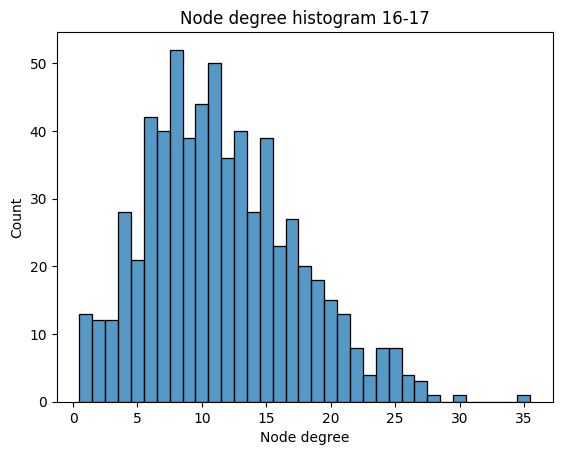

Year 17-18
Granada CF --> 39
Sporting CP --> 29
Middlesbrough --> 29
Barnsley --> 29
VfL Wolfsburg --> 27
Empoli --> 27
Galatasaray SK --> 27
Swansea City --> 27
Fiorentina --> 27
Olympique de Marseille --> 26
Chelsea --> 26
VfB Stuttgart --> 25
AD Alcorcón --> 25
Bury --> 25
Blackburn Rovers --> 25
Bari --> 25
CD Leganés --> 25
Bristol City --> 25
Wigan Athletic --> 25
Udinese --> 24


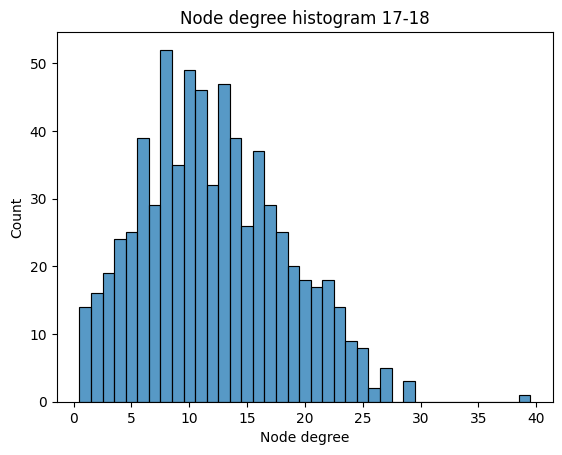

Year 18-19
Peterborough United --> 30
UD Las Palmas --> 29
Deportivo de La Coruña --> 29
Chelsea --> 26
Hellas Verona --> 26
Genoa --> 26
Benevento --> 25
Fulham --> 25
West Ham United --> 25
1. FC Kaiserslautern --> 24
Sporting CP --> 24
Nottingham Forest --> 24
Sunderland --> 24
FC Sochaux-Montbéliard --> 24
CD Leganés --> 23
Bologna --> 23
Bolton Wanderers --> 23
Shrewsbury --> 23
FC Metz --> 22
Udinese --> 22


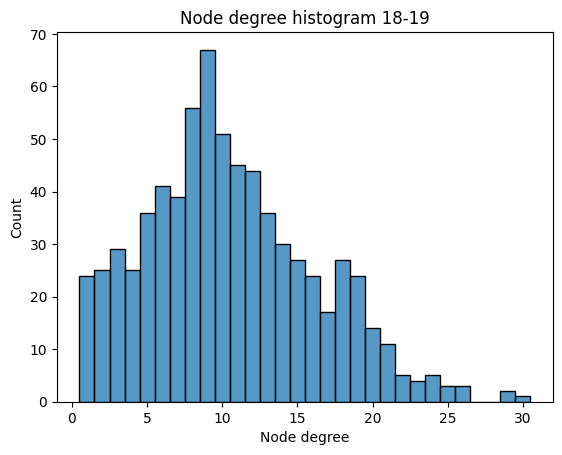

Year 19-20
SD Huesca --> 26
Aston Villa --> 26
Wigan Athletic --> 26
Genoa --> 25
VfB Stuttgart --> 24
Cádiz CF --> 24
Northampton Town --> 24
Fenerbahçe SK --> 24
Shrewsbury --> 24
Queens Park Rangers --> 24
AS Monaco --> 23
Galatasaray SK --> 23
Nottingham Forest --> 23
Barnsley --> 23
Boca Juniors --> 23
Empoli --> 23
Rangers FC --> 23
Millwall --> 23
Holstein Kiel --> 22
Sevilla FC --> 22


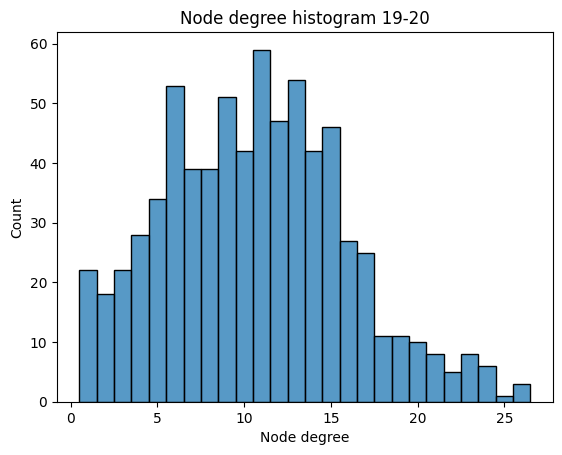

Year 20-21
Genoa --> 28
Vitória Guimarães --> 26
Blackpool --> 24
SG Dynamo Dresden --> 22
AS Monaco --> 22
1. FC Union Berlin --> 21
Villarreal CF --> 21
KAA Gent --> 21
Nottingham Forest --> 21
Gillingham --> 21
Defensa y Justicia --> 21
RSC Anderlecht --> 21
Fenerbahçe SK --> 20
Wigan Athletic --> 20
Málaga CF --> 20
CD Leganés --> 20
1. FC Köln --> 19
Hannover 96 --> 19
SV Wehen Wiesbaden --> 19
SC Freiburg --> 19


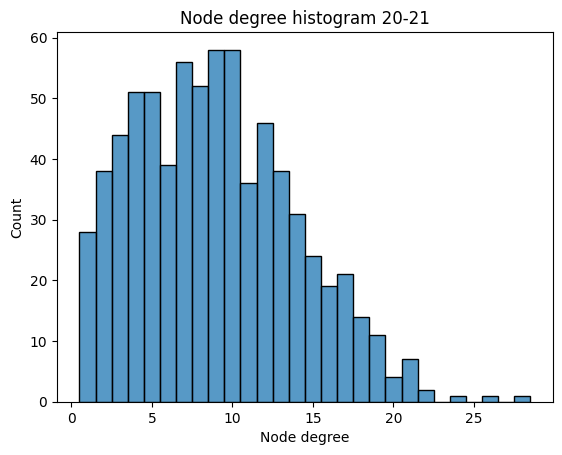

In [16]:
degree_per_year = []

for graph, year in zip(graphs.values(), range(15, 21)):
    degree = {n: graph.degree(n) for n in graph.nodes()}
    sorted_degree = sorted(degree.items(), key= lambda item: item[1], reverse=True)
    degree_per_year.append(sorted_degree)
    sorted_degree = sorted_degree[:TOP_DISPLAY]
    print(f"Year {year}-{year+1}")
    for club, transfers in sorted_degree:
        print(f"{club} --> {transfers}")
    ax = sns.histplot(degree, discrete=True)
    plt.title(f"Node degree histogram {year}-{year+1}")
    plt.xlabel("Node degree")
    plt.ylabel("Count")
    plt.show()

In [17]:
team_degree_ranking = []
for year in degree_per_year:
    team_degree_ranking.append([x[0] for x in year])
best_degree_teams = [(x[0], []) for x in team_degree_ranking]

for team, arr in best_degree_teams:
    for ranking in team_degree_ranking:
        arr.append(ranking.index(team)+1)
best_degree_teams
        

[('Wigan Athletic', [1, 26, 19, 52, 3, 14]),
 ('Granada CF', [3, 1, 1, 119, 286, 89]),
 ('Granada CF', [3, 1, 1, 119, 286, 89]),
 ('Peterborough United', [364, 18, 161, 1, 153, 227]),
 ('SD Huesca', [435, 87, 276, 152, 1, 135]),
 ('Genoa', [5, 38, 21, 6, 4, 1])]

#### Co łączy kluby wykonujące najwięcej transferów?
Każdy z klubów nie jest stabilnym uczestnikiem najwyższej ligi rozgrywek w swoim regionie.

#### Czy najczęśniej dokonujące transferów kluby jednorazowo wymieniają dużą część składu, czy dzieje się to co rok?
Kluby dzielą się na dwie kategorie:
- kluby, które po wykonaniu dużej liczby transferów stabilizują swój podstawowy skład
- kluby, które z roku na rok wymieniają dużą liczbę zawodników, pełniące funkcję okresu przejściowego dla zawodników


Year 15-16
Wigan Athletic --> 0.03223
Queens Park Rangers --> 0.02906
Córdoba CF --> 0.02764
FC Porto --> 0.02718
Atlético Madrid --> 0.02558
Olympique de Marseille --> 0.02518
CD O'Higgins --> 0.0244
Hellas Verona --> 0.02406
Aston Villa --> 0.02315
Blackpool --> 0.02195
Rotherham United --> 0.02176
Granada CF --> 0.02118
Elche CF --> 0.02108
Universidad Católica --> 0.01936
Reading --> 0.01841
Brentford --> 0.01836
Suwon Samsung Bluewings --> 0.01831
Sampdoria --> 0.01801
Watford --> 0.01795
Al Ittihad --> 0.0179


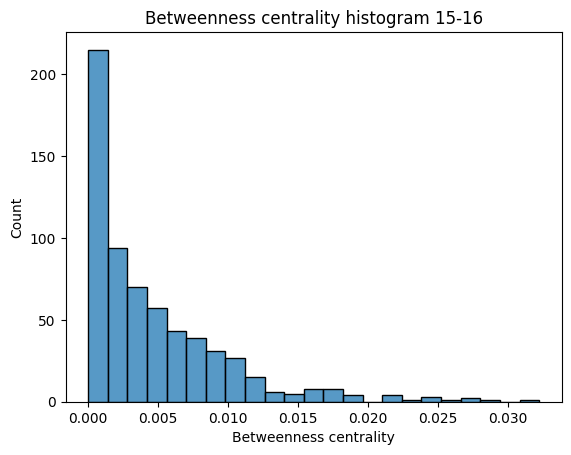

Year 16-17
Boca Juniors --> 0.03331
Sporting CP --> 0.0237
Newcastle United --> 0.02183
Fulham --> 0.02088
Granada CF --> 0.02023
Leeds United --> 0.01929
West Ham United --> 0.01858
Vitória Guimarães --> 0.01827
Hamburger SV --> 0.01821
Queens Park Rangers --> 0.01814
Huddersfield Town --> 0.01811
Getafe CF --> 0.01677
Melbourne City FC --> 0.01602
Peterborough United --> 0.01599
SV Werder Bremen --> 0.01553
San Lorenzo de Almagro --> 0.01526
Middlesbrough --> 0.01523
VfB Stuttgart --> 0.01495
Wolverhampton Wanderers --> 0.01491
Independiente Medellín --> 0.0148


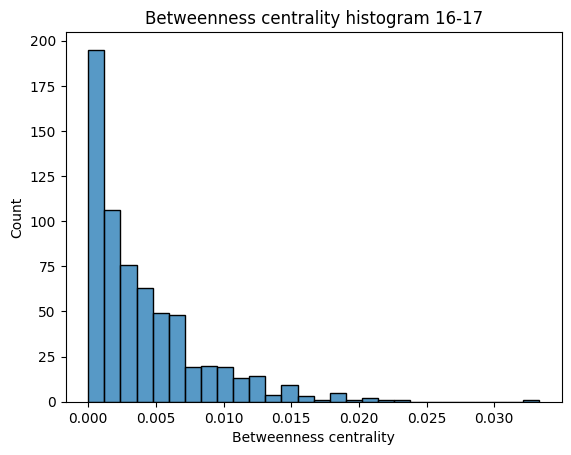

Year 17-18
Granada CF --> 0.02298
Sporting CP --> 0.01964
Sagan Tosu --> 0.01902
Eintracht Frankfurt --> 0.01696
Nottingham Forest --> 0.01631
Bristol City --> 0.01598
Rangers FC --> 0.0148
VfB Stuttgart --> 0.01472
VfL Wolfsburg --> 0.01452
Middlesbrough --> 0.01452
Wolverhampton Wanderers --> 0.0145
Club Atlético Tigre --> 0.01445
1. FC Kaiserslautern --> 0.01354
Galatasaray SK --> 0.0135
Barnsley --> 0.0134
Panathinaikos FC --> 0.01334
Swansea City --> 0.0132
Deportivo Cali --> 0.01316
FC Schalke 04 --> 0.01286
Udinese --> 0.01266


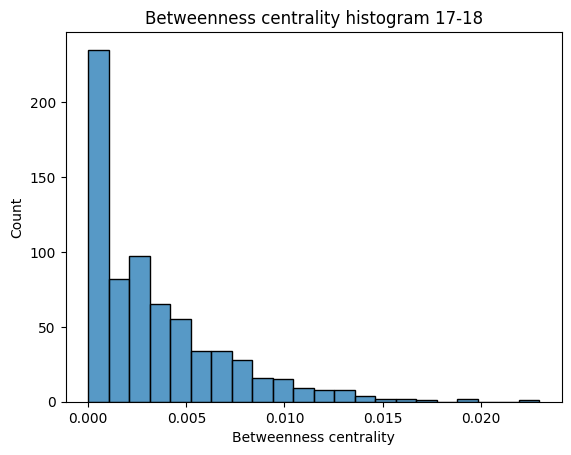

Year 18-19
Deportivo de La Coruña --> 0.02257
Leeds United --> 0.01895
UD Las Palmas --> 0.01783
Olympiacos CFP --> 0.01717
West Ham United --> 0.01701
Genoa --> 0.01693
Watford --> 0.016
Chelsea --> 0.01595
Udinese --> 0.01592
Nottingham Forest --> 0.01562
Brighton & Hove Albion --> 0.01522
SV Werder Bremen --> 0.01511
FC Metz --> 0.01509
Wellington Phoenix --> 0.01487
Sporting CP --> 0.0146
Rangers FC --> 0.01453
FC Basel 1893 --> 0.01437
Hellas Verona --> 0.01434
Wolverhampton Wanderers --> 0.0141
Sunderland --> 0.01409


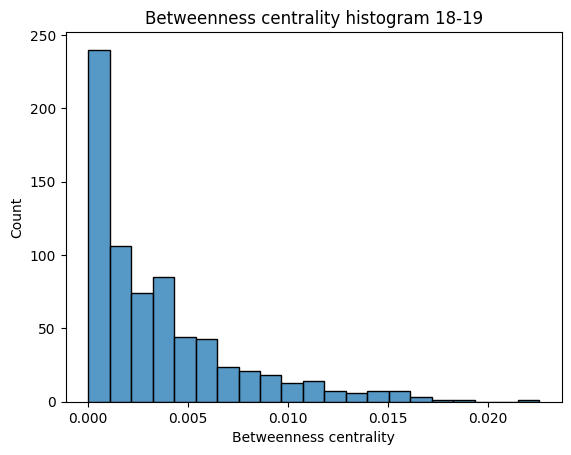

Year 19-20
Genoa --> 0.02312
FC Porto --> 0.02002
FC Nantes --> 0.0197
Reading --> 0.01912
Aston Villa --> 0.01843
Fenerbahçe SK --> 0.01838
Boca Juniors --> 0.01814
Ajax --> 0.01666
Rangers FC --> 0.01599
Hannover 96 --> 0.01592
FC Groningen --> 0.0158
Vancouver Whitecaps FC --> 0.01562
Sevilla FC --> 0.01548
VfB Stuttgart --> 0.01495
KRC Genk --> 0.01488
Brentford --> 0.01475
Molde FK --> 0.01456
PSV --> 0.01444
Chicago Fire --> 0.01365
AS Monaco --> 0.01341


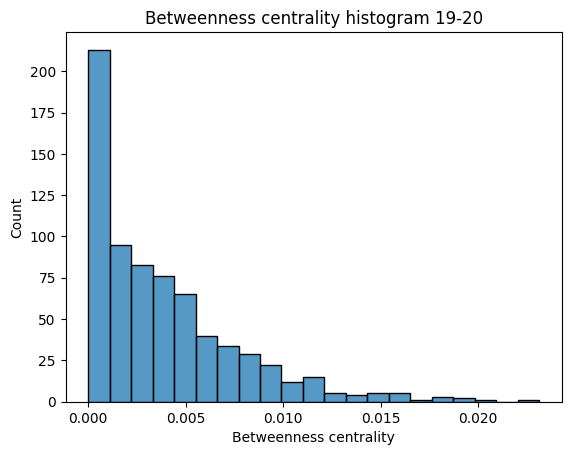

Year 20-21
Genoa --> 0.02689
Vitória Guimarães --> 0.02653
KRC Genk --> 0.02121
KAA Gent --> 0.02105
Fenerbahçe SK --> 0.02084
Rosario Central --> 0.02069
AS Monaco --> 0.01866
Defensa y Justicia --> 0.0177
PSV --> 0.01704
1. FC Union Berlin --> 0.01641
Kasimpaşa SK --> 0.01575
Nottingham Forest --> 0.01558
Sheffield United --> 0.01555
Villarreal CF --> 0.01554
SL Benfica --> 0.01515
Manchester City --> 0.01512
Fortuna Sittard --> 0.01503
Amiens SC --> 0.01475
Hull City --> 0.01465
SC Freiburg --> 0.01463


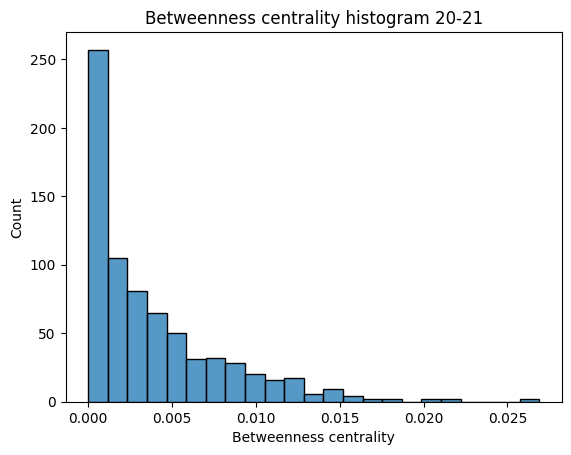

In [18]:
betweenness_per_year = []

for graph, year in zip(graphs.values(), range(15, 21)):
    betweenness_centrality = nx.betweenness_centrality(graph)
    betweenness_sorted = sorted(betweenness_centrality.items(), key= lambda item: item[1], reverse=True)
    betweenness_per_year.append(betweenness_sorted)
    betweenness_sorted = betweenness_sorted[:TOP_DISPLAY]
    print(f"Year {year}-{year+1}")
    for club, transfers in betweenness_sorted:
        print(f"{club} --> {round(transfers, 5)}")
    ax = sns.histplot(betweenness_centrality)
    plt.title(f"Betweenness centrality histogram {year}-{year+1}")
    plt.xlabel("Betweenness centrality")
    plt.ylabel("Count")
    plt.show()

In [19]:
team_betweenness_ranking = []
for year in betweenness_per_year:
    team_betweenness_ranking.append([x[0] for x in year])
best_betweenness_teams = [(x[0], []) for x in team_betweenness_ranking]

for team, arr in best_betweenness_teams:
    for ranking in team_betweenness_ranking:
        arr.append(ranking.index(team)+1)
best_betweenness_teams

[('Wigan Athletic', [1, 37, 171, 108, 38, 152]),
 ('Boca Juniors', [140, 1, 61, 119, 7, 90]),
 ('Granada CF', [12, 5, 1, 102, 225, 119]),
 ('Deportivo de La Coruña', [65, 68, 255, 1, 59, 573]),
 ('Genoa', [25, 59, 58, 6, 1, 1]),
 ('Genoa', [25, 59, 58, 6, 1, 1])]

#### Który z klubów pełnił kluczową rolę w przepływie transferów między klubami?
Genoa

Year 15-16
Wigan Athletic --> 0.27421
Hellas Verona --> 0.27266
Sampdoria --> 0.2703
Olympique de Marseille --> 0.27003
FC Porto --> 0.26975
Real Madrid --> 0.26948
Granada CF --> 0.26811
Atlético Madrid --> 0.2669
Palermo --> 0.26557
Genoa --> 0.2653
Manchester United --> 0.26477
Parma --> 0.26267
Rotherham United --> 0.26254
Manchester City --> 0.26164
Queens Park Rangers --> 0.26061
Elche CF --> 0.26035
Chelsea --> 0.26023
Fiorentina --> 0.26023
Fulham --> 0.25997
Juventus --> 0.25959


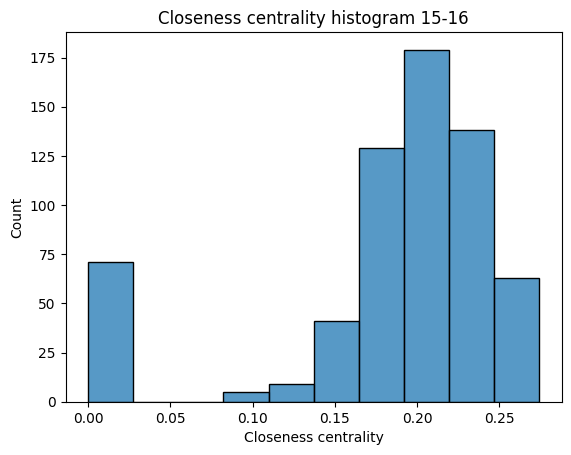

Year 16-17
Sunderland --> 0.28289
Newcastle United --> 0.28141
Sporting CP --> 0.27591
RSC Anderlecht --> 0.27506
Olympique de Marseille --> 0.27478
Swansea City --> 0.27352
Getafe CF --> 0.27338
Reading --> 0.27324
Málaga CF --> 0.2724
Granada CF --> 0.27171
Valencia CF --> 0.27103
VfB Stuttgart --> 0.27075
Queens Park Rangers --> 0.27075
RCD Espanyol --> 0.27048
Boca Juniors --> 0.27034
Real Sporting de Gijón --> 0.26939
West Ham United --> 0.26926
Sevilla FC --> 0.26899
Charlton Athletic --> 0.26885
Aston Villa --> 0.26885


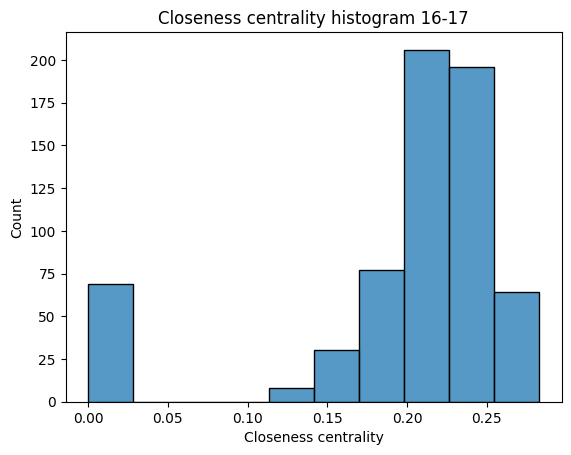

Year 17-18
Granada CF --> 0.2865
Middlesbrough --> 0.27243
Real Betis --> 0.27117
FC Schalke 04 --> 0.27075
Ajax --> 0.26937
Sporting CP --> 0.26786
VfL Wolfsburg --> 0.26786
Galatasaray SK --> 0.26745
PSV --> 0.26624
Standard de Liège --> 0.26597
West Ham United --> 0.2649
Fiorentina --> 0.2645
Nottingham Forest --> 0.26437
Sevilla FC --> 0.26423
Real Madrid --> 0.26397
Valencia CF --> 0.26344
Panathinaikos FC --> 0.26252
Chelsea --> 0.26239
Empoli --> 0.26213
CD Leganés --> 0.26109


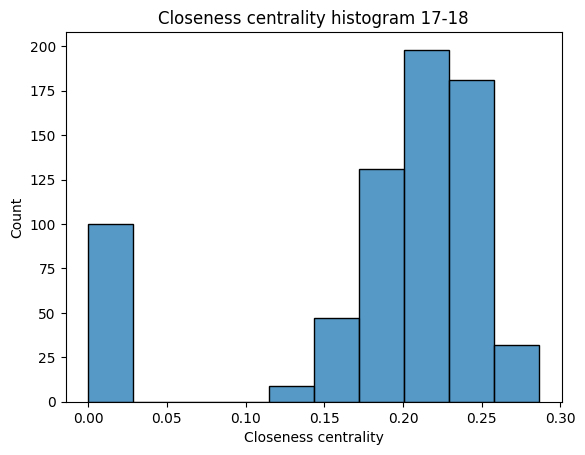

Year 18-19
Deportivo de La Coruña --> 0.26534
Leeds United --> 0.26275
Sporting CP --> 0.25896
Arsenal --> 0.25784
Borussia Dortmund --> 0.25784
Sevilla FC --> 0.25613
UD Las Palmas --> 0.25576
West Ham United --> 0.25395
Swansea City --> 0.25347
VfB Stuttgart --> 0.2524
Fulham --> 0.25099
Rangers FC --> 0.24983
AS Saint-Étienne --> 0.24948
1. FSV Mainz 05 --> 0.24913
FC Twente --> 0.2489
Getafe CF --> 0.2481
Granada CF --> 0.24798
Chelsea --> 0.24798
Middlesbrough --> 0.24798
FC Metz --> 0.24753


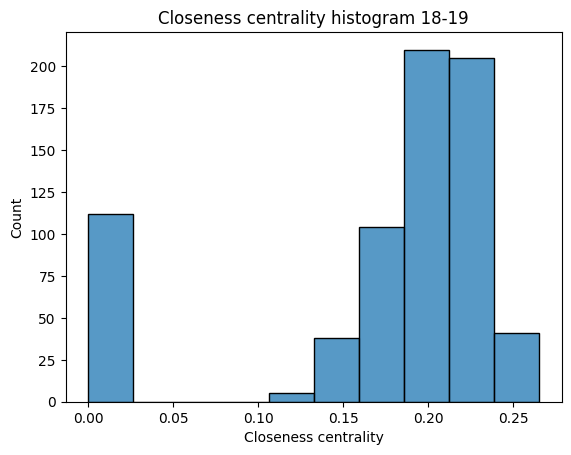

Year 19-20
Genoa --> 0.25691
Fulham --> 0.25573
Borussia Dortmund --> 0.25515
Chelsea --> 0.2548
AS Monaco --> 0.25387
Hannover 96 --> 0.25272
Sporting CP --> 0.25078
Toulouse Football Club --> 0.25045
Real Madrid --> 0.25033
Sevilla FC --> 0.25022
VfB Stuttgart --> 0.25011
Atlético Madrid --> 0.24988
Liverpool --> 0.24966
Paris Saint-Germain --> 0.24888
SL Benfica --> 0.24877
Manchester City --> 0.24866
FC Bayern München --> 0.24855
Levante UD --> 0.24766
Sampdoria --> 0.24733
Reading --> 0.24722


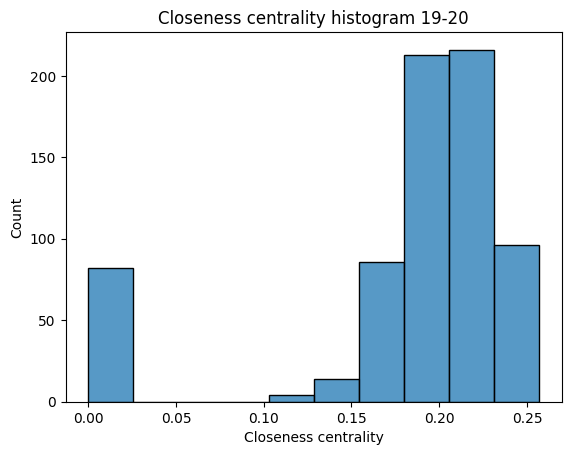

Year 20-21
RB Leipzig --> 0.24029
Sevilla FC --> 0.23753
RSC Anderlecht --> 0.23753
Olympique Lyonnais --> 0.23565
Ajax --> 0.23555
PSV --> 0.23514
Wigan Athletic --> 0.23483
Villarreal CF --> 0.23442
Swansea City --> 0.23401
SC Freiburg --> 0.2332
Wolverhampton Wanderers --> 0.23229
Tottenham Hotspur --> 0.23179
Valencia CF --> 0.23129
Manchester City --> 0.2297
Fulham --> 0.22853
FC St. Pauli --> 0.2267
Norwich City --> 0.22612
Paris Saint-Germain --> 0.22489
Fortuna Sittard --> 0.22489
Heracles Almelo --> 0.22433


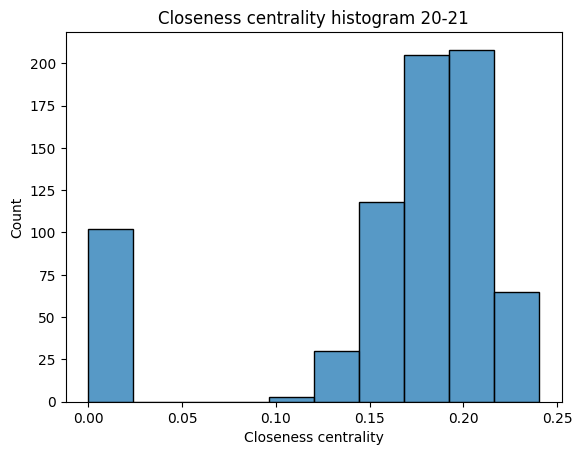

In [20]:
closeness_per_year = []

for graph, year in zip(graphs.values(), range(15, 21)):
    closeness_centrality = nx.closeness_centrality(graph)
    closeness_sorted = sorted(closeness_centrality.items(), key= lambda item: item[1], reverse=True)
    closeness_per_year.append(closeness_sorted)
    closeness_sorted = closeness_sorted[:TOP_DISPLAY]
    print(f"Year {year}-{year+1}")
    for club, transfers in closeness_sorted:
        print(f"{club} --> {round(transfers, 5)}")
    ax = sns.histplot(closeness_centrality, bins=10)
    plt.title(f"Closeness centrality histogram {year}-{year+1}")
    plt.xlabel("Closeness centrality")
    plt.ylabel("Count")
    plt.show()

In [21]:
team_closeness_ranking = []
for year in closeness_per_year:
    team_closeness_ranking.append([x[0] for x in year])
best_closeness_teams = [(x[0], []) for x in team_closeness_ranking]

for team, arr in best_closeness_teams:
    for ranking in team_closeness_ranking:
        arr.append(ranking.index(team)+1)
best_closeness_teams

[('Wigan Athletic', [1, 101, 189, 134, 34, 7]),
 ('Sunderland', [126, 1, 25, 23, 43, 246]),
 ('Granada CF', [7, 10, 1, 17, 240, 152]),
 ('Deportivo de La Coruña', [83, 40, 142, 1, 134, 28]),
 ('Genoa', [10, 50, 29, 111, 1, 45]),
 ('RB Leipzig', [135, 145, 120, 68, 182, 1])]

#### (Nie wiem jak zadać pytanie) Taktyki którego klubu są najbardziej znane na świecie?
Granada CF i Genoa

Year 15-16
Al Fateh --> 0.5
FC Seoul --> 0.5
Galway United --> 0.5
SC Wiener Neustadt --> 0.5
Dorados de Sinaloa --> 0.43333
Daejeon Citizen --> 0.41667
Bray Wanderers --> 0.34211
Club Atlético Huracán --> 0.33333
Cortuluá --> 0.33333
Najran SC --> 0.32143
Patriotas Boyacá FC --> 0.30952
Alianza Petrolera --> 0.3
Deportes Iquique --> 0.3
Deportivo Ñublense --> 0.3
Leones Negros de la UdeG --> 0.3
San Luis de Quillota --> 0.3
Defensa y Justicia --> 0.27778
Al Nassr --> 0.25
Tours FC --> 0.25
CD Cobresal --> 0.25


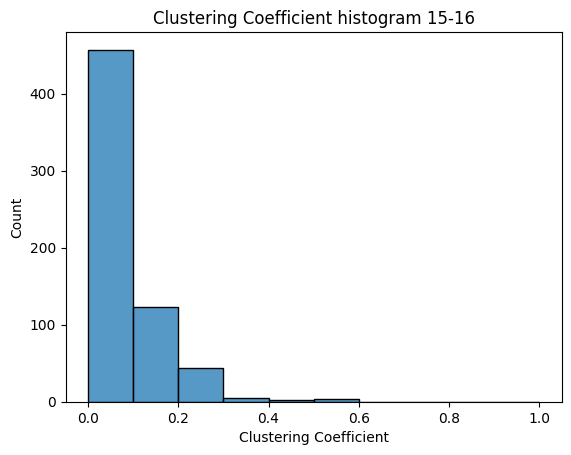

Year 16-17
Adanaspor --> 0.5
Drogheda United --> 0.5
Galway United --> 0.5
KAS Eupen --> 0.5
Wexford Youths --> 0.5
Fortaleza CEIF --> 0.41667
Jeonnam Dragons --> 0.4
CD Cobresal --> 0.38889
Bohemian FC --> 0.33333
Górnik Zabrze --> 0.33333
Deportes Iquique --> 0.33333
Finn Harps --> 0.33333
Mersin İdman Yurdu --> 0.33333
Al Wehda --> 0.32143
Longford Town --> 0.32143
Cortuluá --> 0.30952
Daejeon Citizen --> 0.30952
Athletic Club de Bilbao --> 0.3
Atlético Bucaramanga --> 0.3
GwangJu FC --> 0.3


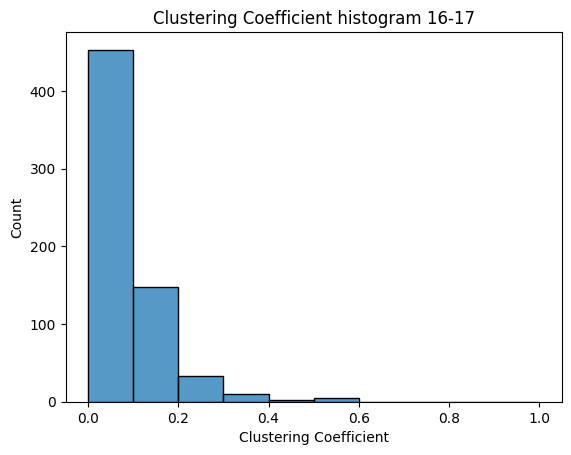

Year 17-18
Vasco da Gama --> 0.58929
Santa Cruz --> 0.56667
Criciúma --> 0.53571
América FC (Minas Gerais) --> 0.51818
Internacional --> 0.51515
Joinville --> 0.50909
CD Everton de Viña del Mar --> 0.5
CD Huachipato --> 0.5
Drogheda United --> 0.5
Górnik Zabrze --> 0.5
Figueirense --> 0.49091
Cruzeiro --> 0.48667
Goiás --> 0.46667
Jeonnam Dragons --> 0.46429
Club Athletico Paranaense --> 0.43373
Ponte Preta --> 0.43333
Bray Wanderers --> 0.41667
Sport Club do Recife --> 0.4163
Palmeiras --> 0.41365
Fluminense --> 0.40959


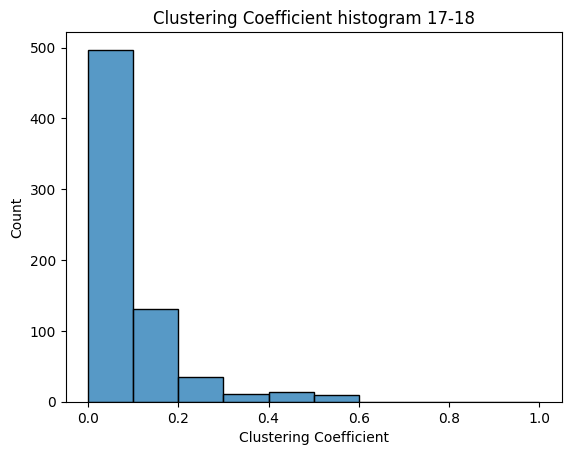

Year 18-19
Gyeongnam FC --> 1.0
Avaí FC --> 0.56944
Coritiba --> 0.5
Esbjerg fB --> 0.5
Drogheda United --> 0.5
TSV Hartberg --> 0.5
Ponte Preta --> 0.48611
Paraná --> 0.47222
Fluminense --> 0.45783
Santos --> 0.44054
Atlético Mineiro --> 0.43675
Cruzeiro --> 0.43667
Atlético Clube Goianiense --> 0.43333
Bray Wanderers --> 0.42308
Envigado FC --> 0.41667
Club Athletico Paranaense --> 0.41566
Internacional --> 0.40909
Grêmio --> 0.40049
FC Luzern --> 0.4
Vitória --> 0.39407


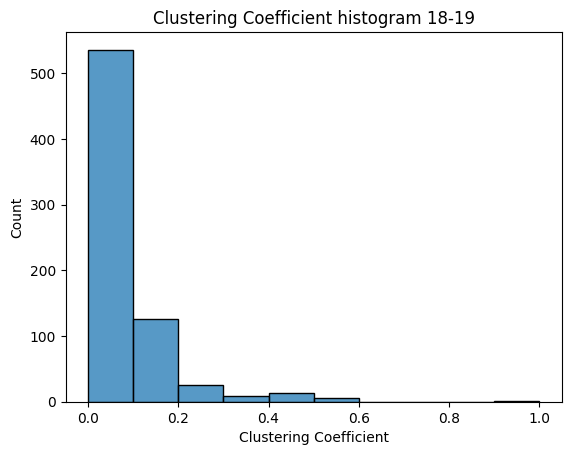

Year 19-20
Vendsyssel FF --> 1.0
Al Adalah --> 0.5
KV Mechelen --> 0.5
Mjøndalen IF --> 0.5
Limerick FC --> 0.5
Incheon United FC --> 0.33824
Derry City --> 0.33333
Kristiansund BK --> 0.33333
Envigado FC --> 0.28571
Once Caldas --> 0.26667
Pisa --> 0.26667
Rionegro Águilas --> 0.26522
Daegu FC --> 0.25
Jeonnam Dragons --> 0.25
Unión Magdalena --> 0.25
Alianza Petrolera --> 0.24074
Gangwon FC --> 0.24074
Atlético Bucaramanga --> 0.2402
Junior FC --> 0.23846
Sangju Sangmu FC --> 0.2381


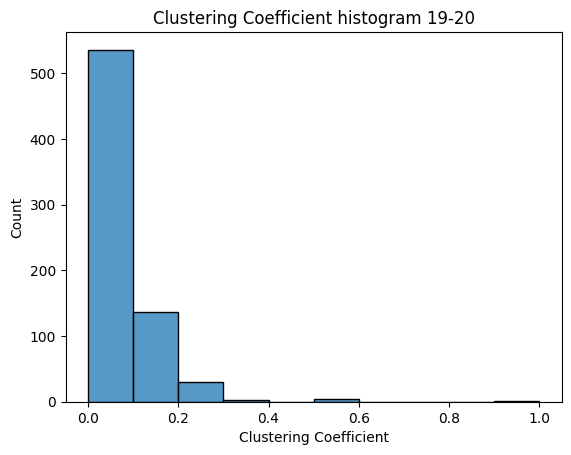

Year 20-21
Patriotas Boyacá FC --> 0.5
Lokomotiv Moscow --> 0.5
Rionegro Águilas --> 0.5
Sligo Rovers --> 0.5
CD Huachipato --> 0.5
Central Coast Mariners --> 0.5
Bury --> 0.5
Henan Jianye FC --> 0.5
GwangJu FC --> 0.45
Daegu FC --> 0.40741
Al Hilal --> 0.375
Suwon Samsung Bluewings --> 0.37143
Incheon United FC --> 0.37143
Bohemian FC --> 0.35714
Ranheim Fotball --> 0.33333
Monterrey --> 0.33333
Jiangsu Suning FC --> 0.33333
AFC Eskilstuna --> 0.33333
Pohang Steelers --> 0.325
Gyeongnam FC --> 0.3


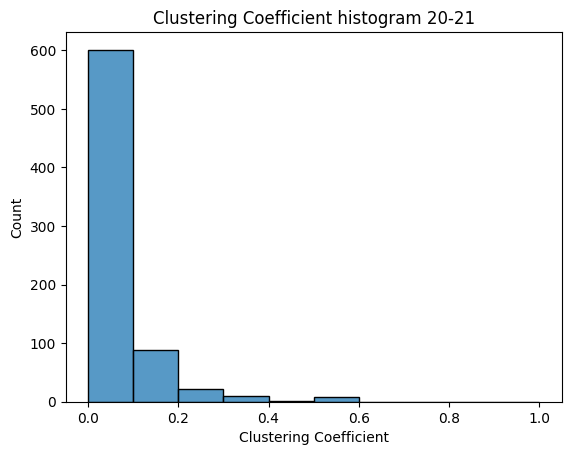

In [22]:
clustering_per_year = []

for graph, year in zip(graphs.values(), range(15, 21)):
    clustering_coefficient = nx.clustering(graph)
    clustering_sorted = sorted(clustering_coefficient.items(), key= lambda item: item[1], reverse=True)
    clustering_per_year.append(clustering_sorted)
    clustering_sorted = clustering_sorted[:TOP_DISPLAY]
    print(f"Year {year}-{year+1}")
    for club, transfers in clustering_sorted:
        print(f"{club} --> {round(transfers, 5)}")
    
    bins = np.arange(0, 1.1, step=0.1)
    ax = sns.histplot(list(clustering_coefficient.values()), bins=bins)
    plt.title(f"Clustering Coefficient histogram {year}-{year+1}")
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Count")
    plt.show()

In [23]:
team_clustering_ranking = []
for year in clustering_per_year:
    team_clustering_ranking.append([x[0] for x in year])
best_clustering_teams = [(x[0], []) for x in team_clustering_ranking]

for team, arr in best_clustering_teams:
    for ranking in team_clustering_ranking:
        if team in ranking:
            arr.append(ranking.index(team)+1)
        else:
            arr.append(-1)
best_clustering_teams

[('Al Fateh', [1, 482, 167, 42, 136, 65]),
 ('Adanaspor', [-1, 1, 683, -1, -1, -1]),
 ('Vasco da Gama', [-1, -1, 1, -1, -1, -1]),
 ('Gyeongnam FC', [365, -1, -1, 1, 40, 20]),
 ('Vendsyssel FF', [-1, -1, -1, 714, 1, -1]),
 ('Patriotas Boyacá FC', [11, 56, 102, 54, 90, 1])]

#### W których krajach utworzyły się grupy klubów najczęściej wymieniających się piłkarzami?
- Południowa Korea
- Dania
- Brazylia
- Turcja
- Kolumnia
- Arabia Saudyjska

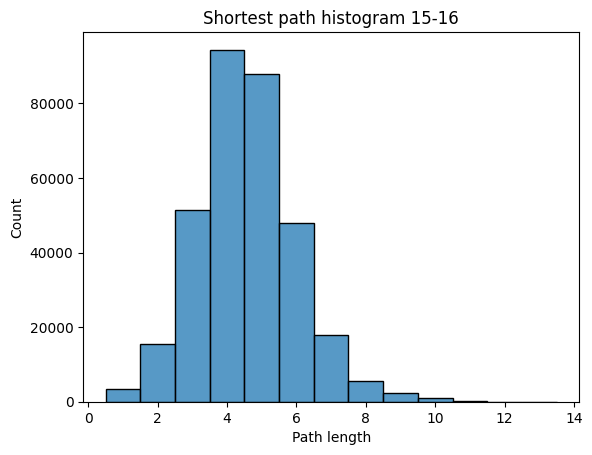

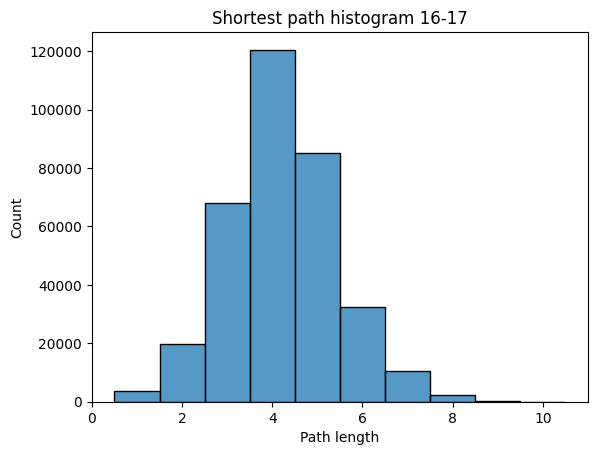

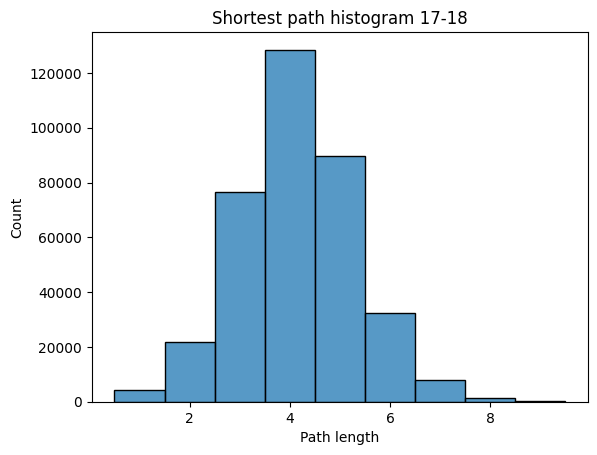

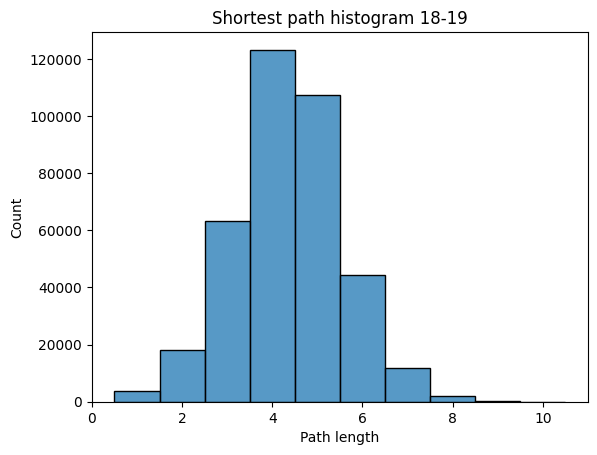

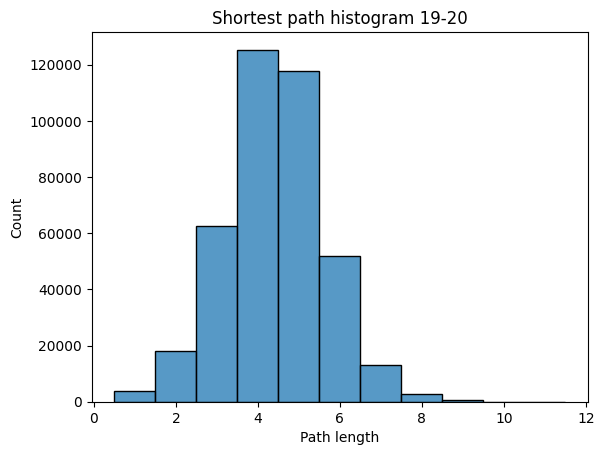

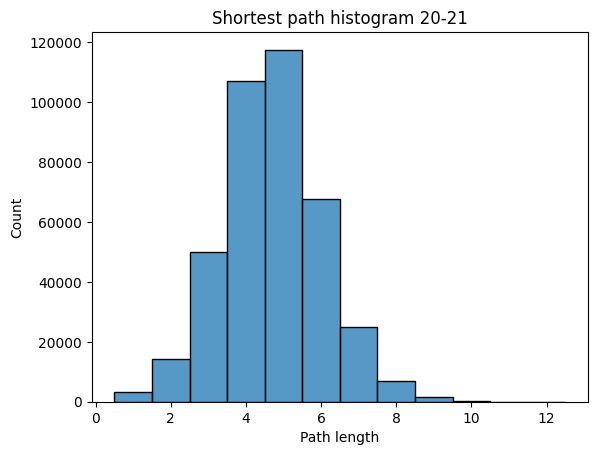

In [28]:
longest_shortest_paths = []

for graph, year in zip(graphs.values(), range(15, 21)):
    shortest_paths = list(nx.shortest_path_length(graph))
    lengths = []
    for node1, connections in shortest_paths:
        for node2, length in connections.items():
            if node1 == node2:
                continue
        
            lengths.append(length)

    longest_shortest_paths.append(np.max(lengths))

    ax = sns.histplot(lengths, discrete=True)
    plt.title(f"Shortest path histogram {year}-{year+1}")
    plt.xlabel("Path length")
    plt.ylabel("Count")
    plt.show()

In [30]:
longest_shortest_paths

[13, 10, 9, 10, 11, 12]

#### Hipoteza sześciu stopni oddalenia w transferowym świecie piłki nożnej
W różnych latach wartość zmienia się, oscylując między 9-13. Jednak znajomości są liczone tylko w roku danego transferu.